In [1]:
#Importing modules, tools, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler




#importing main dataframe as df
df = pd.read_csv('data/kc_house_data.csv')

### Data Cleaning

In [2]:
#Converting grade column to an int value

#Create a dummy list
grade_num = []

#Go through each row, grabbing the first index off the string, conver to int
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))

#drop the old column and add the new
df['grade_num'] = grade_num
df.drop('grade', axis = 1);

Converting the grade to a numeric value.  For the sake of consistency, it was descided to keep the scale provided by the city, however, we will later process this data into categorical data.

In [3]:
# Turning NaNs in the waterfront data into NO's, then converting waterfront to binary.
# 0 is a waterfront no, 1 is a waterfront yes
#

df.waterfront.fillna(value='NO', inplace = True)
df.waterfront.replace( to_replace = ['NO','YES'], value =  [0,1], inplace = True)

A quick check on a random sample of the NaN's within the waterfront column via the lat/long provided showed that these properties were not on the waterfront. It was decided that we'd fill in the Nan's as nos.

12764    13540
7245     12050
3910     10040
9245      9890
8085      9640
         ...  
11488      420
8614       410
21316      390
860        380
15367      370
Name: sqft_living, Length: 21597, dtype: int64
4980.0


<AxesSubplot:ylabel='Frequency'>

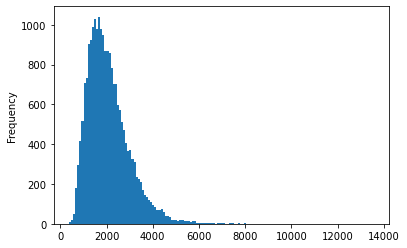

In [4]:
print(df['sqft_living'].sort_values(ascending = False))
#Those are some big results.
print(df['sqft_living'].quantile(0.99))
# even the 99 percentile is still sub 5000. 
binvar = np.sqrt(df.sqft_living.count())
df['sqft_living'].plot(kind = 'hist', bins = int(binvar))
#Plotting this shows a bit skew right.

#It may be wise to shave the model off around there.

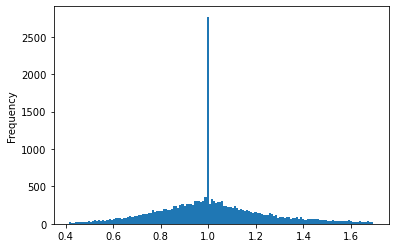

In [5]:
df.sqft_living.describe()
df['sqft_living_ratio'] = df['sqft_living'] / df['sqft_living15']
df.sqft_living_ratio.describe()

df['sqft_living_ratio'] = df.sqft_living / df.sqft_living15
df['sqft_living_ratio'] = df['sqft_living_ratio'].loc[(np.abs(stats.zscore(df.sqft_living_ratio)) < 2)]
df = df.dropna(subset = ['sqft_living_ratio'])
df.sqft_living_ratio.plot(kind = 'hist', bins = int(binvar));

1717     1651359
17305    1164794
7640     1074218
3945      982998
4437      982278
          ...   
21536        638
20588        635
3449         609
7582         600
5821         572
Name: sqft_lot, Length: 20621, dtype: int64
206478.8


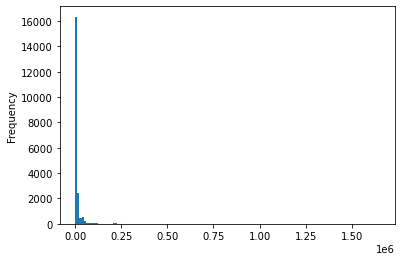

In [6]:
print(df['sqft_lot'].sort_values(ascending = False)) 
#Holy cow! I don't think those are residential sales.
print(df['sqft_lot'].quantile(0.99))
#99th quantile, still high, still well below those outliers

df['sqft_lot'].plot(kind = 'hist', bins = int(binvar));
#Some weirdness at the far end

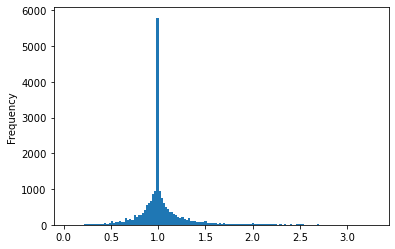

In [7]:
df.sqft_lot15.describe()
df['sqft_lot_ratio'] = df['sqft_lot'] / df['sqft_lot15']
df.sqft_lot_ratio.describe()

df['sqft_lot_ratio'] = df.sqft_lot / df.sqft_lot15
df['sqft_lot_ratio'] = df['sqft_lot_ratio'].loc[(np.abs(stats.zscore(df.sqft_lot_ratio)) < 2)]
df = df.dropna(subset = ['sqft_lot_ratio'])
df.sqft_lot_ratio.plot(kind = 'hist', bins = int(binvar));

The data exploration above showed some outliers. The 'sqft_~_ratio' variables were created to weed out outliers. In effect, if a lot size or living sq ft size was too different from the neighboring property, then it was deemed an outlier. Dropping outliers this way allowed us to, e.g. keep a large mansion in a neighborhood of large mansions.

In [8]:
print(df.bedrooms.value_counts())
bedstandev = np.std(df.bedrooms)
#outliter threshold is often set at 3 std devs
upper_bound = df.bedrooms.mean() + bedstandev * 3
df= df[df.bedrooms <= upper_bound]

3     9520
4     6426
2     2662
5     1379
6      198
1      166
7       23
8        7
10       2
9        2
33       1
Name: bedrooms, dtype: int64


One house had wildely more bedrooms than any others. This is a weird one because eventually we're going to make bedrooms an ordinal categorical dataset. But, to put some rigour in the outlier reduction process, went ahead and did a 3x standard dev test anyway.

In [9]:
df['view'] = df['view'].replace({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'FAIR': 3, 'EXCELLENT':4}).fillna(0)


As with grade, we will later process this into categorical data.

In [10]:
df['floors'].value_counts()
#Seems reasonable. 

1.0    10231
2.0     7653
1.5     1752
3.0      575
2.5      134
3.5        6
Name: floors, dtype: int64

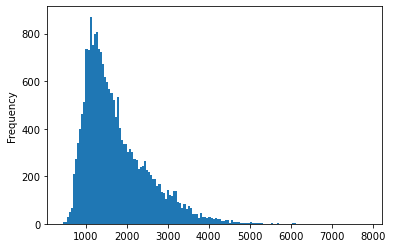

In [11]:
#cleaning the square feet above ground data
df['sqft_above'].sort_values(ascending = False)
#Not quite as extreme as sqft_livable

df['sqft_above'].plot(kind = 'hist', bins = int(binvar));

In [12]:
#cleaning the basement data
df['sqft_basement'] = df['sqft_basement'].replace({'?': 0.0})
df['sqft_basement'] = df['sqft_basement'].astype(float)

Lacking other information, it was decided to assume that unknown basement square footage would be captured in sqft_livable and ? was set to 0. 

Now that the data has been given a preliminary cleaning, a correlation heatmap was generated.


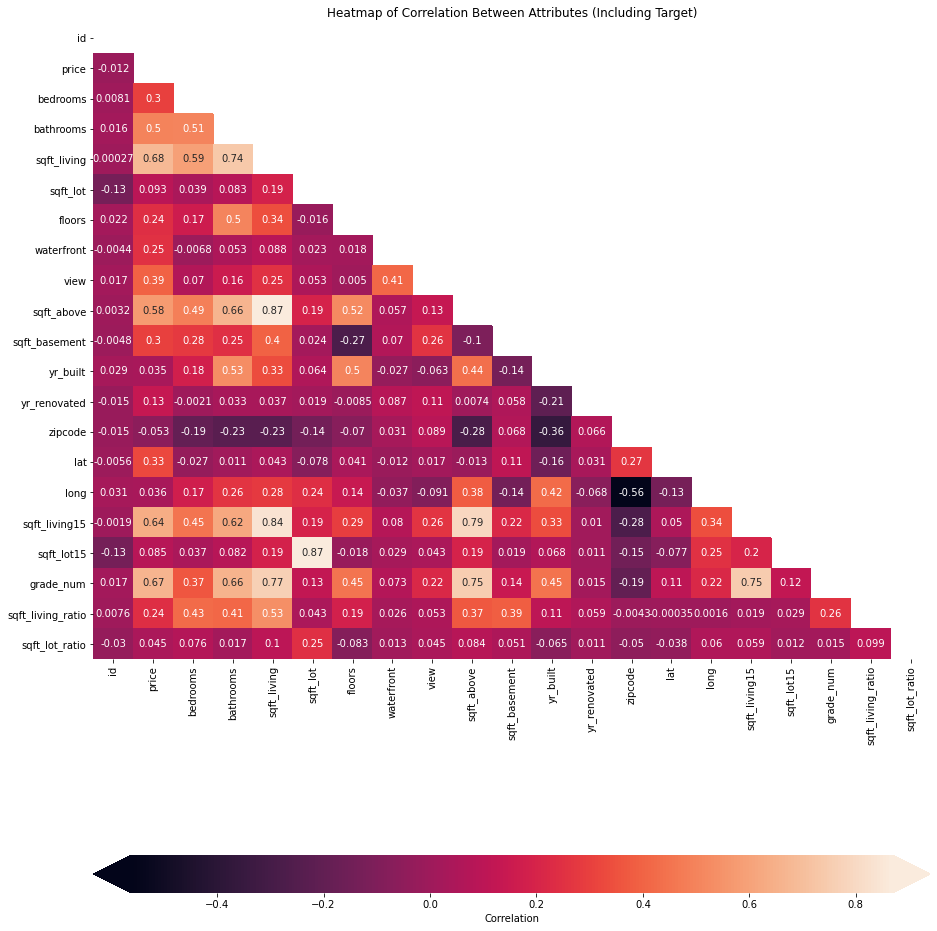

In [13]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 18))
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [14]:
ohe = OneHotEncoder(sparse = False)
ohe.fit_transform(df[['zipcode']])
zip_encoded = ohe.fit_transform(df[['zipcode']])
zip_enc_df = pd.DataFrame(zip_encoded, columns=ohe.categories_[0], index=df.index)
df_original = pd.concat([df, zip_enc_df], axis=1)
ziplist = ohe.categories_[0].tolist()
zipliststr = []
for i in ziplist: 
    zipliststr.append(str(i))

In [15]:
ord_enc = OrdinalEncoder()
ord_enc_f_t = ord_enc.fit_transform(df[['bedrooms','bathrooms','floors','grade_num']])
ord_enc_df = pd.DataFrame(ord_enc_f_t, columns = ['bedrooms_cat','bathrooms_cat','floors_cat','grade_num_cat'], index=df.index)

df_ord = pd.concat([df_original, ord_enc_df], axis=1)


df_ord

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98168,98177,98178,98188,98198,98199,bedrooms_cat,bathrooms_cat,floors_cat,grade_num_cat
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,2.0,3.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,0.0,3.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,4.0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,4.0,4.0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,2.0,4.0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,4.0


These cells encodes the zipcode data, and creates a variable of strings to use as column names later.

Additionally, it processes a number of variables (bedrooms, bathrooms, floors and grade) into ordinal categorical data. 

With this, basic preprocessing is done.

### Spliting the data into testing and training sets

In [16]:
X = df_ord.drop(columns = ['id','date','lat','long','sqft_living_ratio','sqft_lot_ratio','condition','yr_built','yr_renovated','grade','zipcode','bedrooms','bathrooms','grade_num','floors'])
X


,price,sqft_living,sqft_lot,waterfront,view,sqft_above,sqft_basement,sqft_living15,sqft_lot15,98001,...,98168,98177,98178,98188,98198,98199,bedrooms_cat,bathrooms_cat,floors_cat,grade_num_cat
0,221900.0,1180,5650,0,0.0,1180,0.0,1340,5650,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0
1,538000.0,2570,7242,0,0.0,2170,400.0,1690,7639,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,2.0,3.0
3,604000.0,1960,5000,0,0.0,1050,910.0,1360,5000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,0.0,3.0
4,510000.0,1680,8080,0,0.0,1680,0.0,1800,7503,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,4.0
5,1230000.0,5420,101930,0,0.0,3890,1530.0,4760,101930,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,1131,0,0.0,1530,0.0,1530,1509,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,4.0,4.0
21593,400000.0,2310,5813,0,0.0,2310,0.0,1830,7200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,2.0,4.0
21594,402101.0,1020,1350,0,0.0,1020,0.0,1020,2007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0
21595,400000.0,1600,2388,0,0.0,1600,0.0,1410,1287,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,4.0


### The baseline model



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='price'),X.price, test_size = .25, random_state = 420)

training_data = pd.concat([X_train,y_train], axis = 1)
testing_data = pd.concat([X_test,y_test], axis = 1)

dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X_train,y_train)
dummy_regr.predict(X_train)
dummy_regr.predict(X_test)
dummy_regr.score(X_train, y_train)
dummy_regr.score(X_test, y_test)
dummy_train_RMSE = MSE(y_train,dummy_regr.predict(X_train),squared = False)
dummy_test_RMSE = MSE(y_test,dummy_regr.predict(X_test), squared = False)

print()
print(f'Baseline Model Train Score: {dummy_regr.score(X_train, y_train)}')
print(f'Baseline Model Train RMSE: {round(dummy_train_RMSE)}')
print()
print(f'Baseline Model Test Score: {dummy_regr.score(X_test, y_test)}')
print(f'Baseline Model Test RMSE: {round(dummy_test_RMSE)}')


Baseline Model Train Score: 0.0
Baseline Model Train RMSE: 330162.0

Baseline Model Test Score: -0.00019223859420502976
Baseline Model Test RMSE: 326897.0


### Our First Simple Model

The baseline model we chose to use was a simple model using the information we grabbed from the correlation heatmap, namely that price's highest correlated variable was livable square feet.

In [18]:
X_train_simple_model = X_train[['sqft_living']]
X_test_simple_model = X_test[['sqft_living']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

simple_model = LinearRegression()
simple_model.fit(X_train_simple_model,y_train)

simple_model_scores = cross_validate(
    estimator=simple_model,
    X=df_ord[['sqft_living']],
    y=df_ord.price,
    return_train_score=True,
    cv=splitter
)

simple_predict_train = simple_model.predict(X_train_simple_model)
simple_predict_test = simple_model.predict(X_test_simple_model)

simple_train_RMSE = MSE(y_train,simple_predict_train,squared = False)
simple_test_RMSE = MSE(y_test,simple_predict_test, squared = False)

simple_condition_num = sm.OLS(y_train, sm.add_constant(X_train_simple_model)).fit().condition_number

print(f'Simple Model Train score: {simple_model_scores["train_score"].mean()}')
print(f'Simple Model Train RMSE: {round(simple_train_RMSE)}')
print(f'Simple Model Train Condition Number: {simple_condition_num}')
print()
print("Simple Model Test score: ", simple_model_scores["test_score"].mean())
print(f'Simple Model Test RMSE: {round(simple_test_RMSE)}')

Simple Model Train score: 0.4637452114223612
Simple Model Train RMSE: 240887.0
Simple Model Train Condition Number: 5698.917237705737

Simple Model Test score:  0.4687208425102188
Simple Model Test RMSE: 240877.0


As we can see, the R-squared score isn't great. 

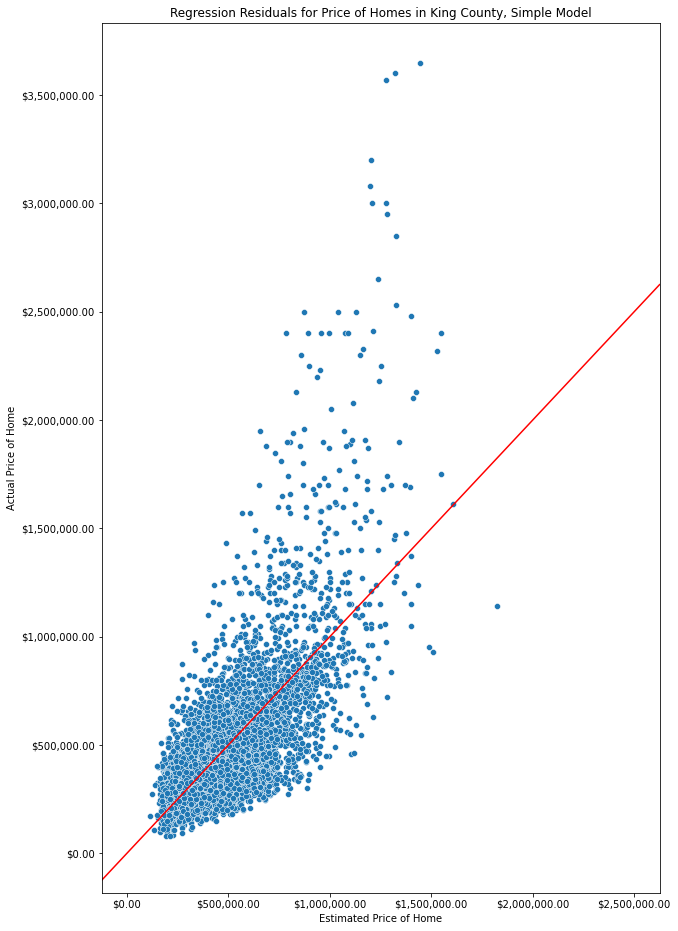

In [19]:
fig, ax = plt.subplots(figsize = (10,16))

sns.scatterplot(x = simple_predict_test, y = y_test, ax=ax)
ax.set_title('Regression Residuals for Price of Homes in King County, Simple Model')
ax.set_xlabel('Estimated Price of Home')
ax.set_ylabel('Actual Price of Home')
ax.ticklabel_format(style='plain') 
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.xaxis.set_major_formatter('${x:1,.2f}')
x,y = [range(0,2500000,500000)],[range(0,2500000,500000)]
plt.axline((0,0),(2500000,2500000), color = 'red')
plt.show()

### The next model, adding in some basic construction facets

In [20]:
X_train_third_model = X_train[['sqft_living','bedrooms_cat','bathrooms_cat']]
X_test_third_model = X_test[['sqft_living','bedrooms_cat','bathrooms_cat']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

third_model = LinearRegression()
third_model.fit(X_train_third_model,y_train)

third_model_scores = cross_validate(
    estimator=simple_model,
    X=df_ord[['sqft_living','bedrooms_cat','bathrooms_cat']],
    y=df_ord.price,
    return_train_score=True,
    cv=splitter
)

third_predict_train = third_model.predict(X_train_third_model)
third_predict_test = third_model.predict(X_test_third_model)

third_train_RMSE = MSE(y_train,third_predict_train,squared = False)
third_test_RMSE = MSE(y_test,third_predict_test, squared = False)

third_condition_num = sm.OLS(y_train, sm.add_constant(X_train_third_model)).fit().condition_number

print(f'Third Model Train score: {third_model_scores["train_score"].mean()}')
print(f'Third Model Train RMSE: {round(third_train_RMSE)}')
print()
print(f'Third Model Train Condition Number: {third_condition_num}')
print()
print("Third Model Test score: ", third_model_scores["test_score"].mean())
print(f'Third Model Test RMSE: {round(third_test_RMSE)}')

Third Model Train score: 0.4789978801719577
Third Model Train RMSE: 237474.0

Third Model Train Condition Number: 7018.405848296658

Third Model Test score:  0.48430839882315874
Third Model Test RMSE: 237201.0


This model performs only slightly better than the model that only looks at 'sqft_living', while also increasing our condition number. Clearly we need to pull in some other factors.

### Model Four, bringing in all the data!

In [21]:
X_train_fourth_model = X_train
X_test_fourth_model = X_test

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

fourth_model = LinearRegression()
fourth_model.fit(X_train_fourth_model,y_train)

fourth_model_scores = cross_validate(
    estimator=simple_model,
    X=X.drop(columns = 'price'),
    y=X.price,
    return_train_score=True,
    cv=splitter
)

fourth_predict_train = fourth_model.predict(X_train_fourth_model)
fourth_predict_test = fourth_model.predict(X_test_fourth_model)

fourth_train_RMSE = MSE(y_train,fourth_predict_train,squared = False)
fourth_test_RMSE = MSE(y_test,fourth_predict_test, squared = False)

fourth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_fourth_model)).fit().condition_number

print(f'Fourth Model Train score: {fourth_model_scores["train_score"].mean()}')
print(f'Fourth Model Train RMSE: {round(fourth_train_RMSE)}')
print()
print(f'Fourth Model Train Condition Number: {fourth_condition_num}')
print()
print("Fourth Model Test score: ", fourth_model_scores["test_score"].mean())
print(f'fourth Model Test RMSE: {round(fourth_test_RMSE)}')

Fourth Model Train score: 0.8125932016440998
Fourth Model Train RMSE: 142884.0

Fourth Model Train Condition Number: 3.591339787033922e+20

Fourth Model Test score:  0.8137391284816822
fourth Model Test RMSE: 141256.0


By r-squared and RMSE we've brought the error way down. However, our condition number has increased dramatically. 

Our model seems to work well for houses under 1.5 million dollars. However, after that point, our model undervalues the price of homes. All the data above the line is homes undervalued by our model, while the data below it is over valued by our model.

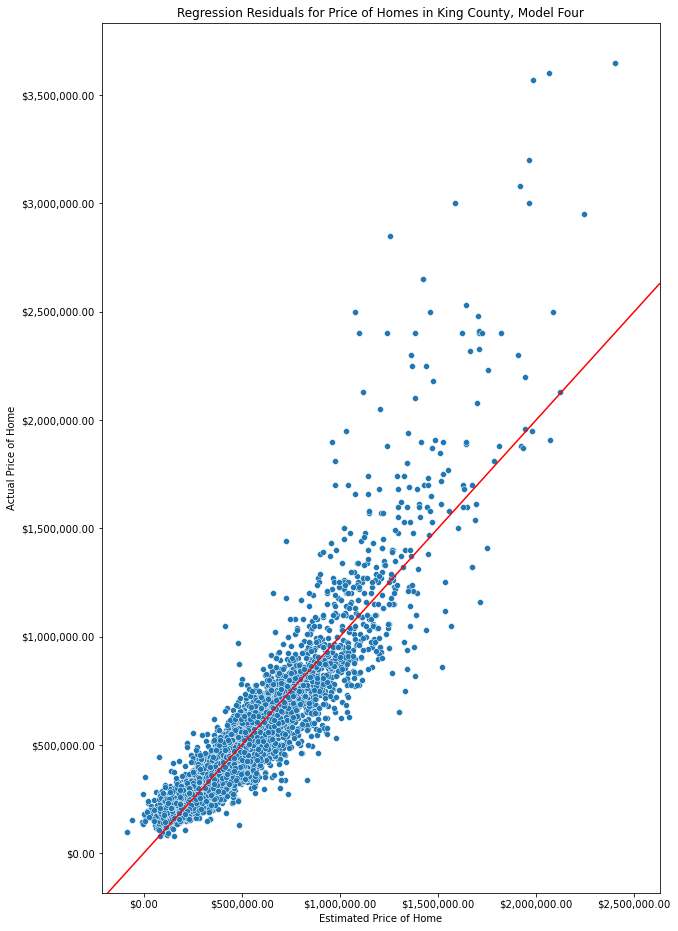

In [22]:
fig, ax = plt.subplots(figsize = (10,16))

fourth_reg_residuals = fourth_predict_test - y_test
sns.scatterplot(x = fourth_predict_test, y = y_test, ax=ax)
ax.set_title('Regression Residuals for Price of Homes in King County, Model Four')
ax.set_xlabel('Estimated Price of Home')
ax.set_ylabel('Actual Price of Home')
ax.ticklabel_format(style='plain') 
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.xaxis.set_major_formatter('${x:1,.2f}')
x,y = [range(0,2500000,500000)],[range(0,2500000,500000)]
plt.axline((0,0),(2500000,2500000), color = 'red')
plt.show()

In [23]:
X_train_for_RFECV = StandardScaler().fit_transform(X_train)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)
selector.ranking_

array([1, 2, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In an effort to bring down the condition number, later versions of the model simplified zipcode data into a binary of in Seattle (listed below) and out of Seattle, the rest of the data set.

In [24]:
Seattle_zipcodes = [98101, 98102, 98103, 98104, 98105, 
                    98106, 98107, 98108, 98109, 98112, 
                    98115, 98116, 98117, 98118, 98119, 
                    98121, 98122, 98125, 98126, 98133, 
                    98134, 98136, 98144, 98146, 98154, 
                    98164, 98174, 98177, 98178, 98195, 
                    98199 ]

df['in_Seattle'] = np.where(df['zipcode'].isin(Seattle_zipcodes),1,0)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,grade_num,sqft_living_ratio,sqft_lot_ratio,in_Seattle
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0.0,...,0.0,98178,47.5112,-122.257,1340,5650,7,0.880597,1.000000,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0.0,...,1991.0,98125,47.7210,-122.319,1690,7639,7,1.520710,0.948030,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0.0,...,0.0,98136,47.5208,-122.393,1360,5000,7,1.441176,1.000000,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0.0,...,0.0,98074,47.6168,-122.045,1800,7503,8,0.933333,1.076903,0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0,0.0,...,0.0,98053,47.6561,-122.005,4760,101930,11,1.138655,1.000000,0


In [25]:
X_with_in_sea =  pd.concat([X, df['in_Seattle']], axis = 1)
for i in zipliststr:
    X_with_in_sea.drop(columns = int(i), inplace = True)

In [26]:
X_with_in_sea

,price,sqft_living,sqft_lot,waterfront,view,sqft_above,sqft_basement,sqft_living15,sqft_lot15,bedrooms_cat,bathrooms_cat,floors_cat,grade_num_cat,in_Seattle
0,221900.0,1180,5650,0,0.0,1180,0.0,1340,5650,2.0,2.0,0.0,3.0,1
1,538000.0,2570,7242,0,0.0,2170,400.0,1690,7639,2.0,7.0,2.0,3.0,1
3,604000.0,1960,5000,0,0.0,1050,910.0,1360,5000,3.0,10.0,0.0,3.0,1
4,510000.0,1680,8080,0,0.0,1680,0.0,1800,7503,2.0,6.0,0.0,4.0,0
5,1230000.0,5420,101930,0,0.0,3890,1530.0,4760,101930,3.0,16.0,0.0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,1131,0,0.0,1530,0.0,1530,1509,2.0,8.0,4.0,4.0,1
21593,400000.0,2310,5813,0,0.0,2310,0.0,1830,7200,3.0,8.0,2.0,4.0,1
21594,402101.0,1020,1350,0,0.0,1020,0.0,1020,2007,1.0,1.0,2.0,3.0,1
21595,400000.0,1600,2388,0,0.0,1600,0.0,1410,1287,2.0,8.0,2.0,4.0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_with_in_sea.drop(columns='price'), X_with_in_sea.price, test_size = .25, random_state = 420)

training_data = pd.concat([X_train,y_train], axis = 1)
testing_data = pd.concat([X_test,y_test], axis = 1)

### Model Five, bringing in 'in Seattle'

In [28]:
X_train_fifth_model = X_train[['sqft_living','bedrooms_cat','bathrooms_cat','in_Seattle']]
X_test_fifth_model = X_test[['sqft_living','bedrooms_cat','bathrooms_cat','in_Seattle']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

fifth_model = LinearRegression()
fifth_model.fit(X_train_fifth_model,y_train)

fifth_model_scores = cross_validate(
    estimator=simple_model,
    X=X_with_in_sea[['sqft_living','bedrooms_cat','bathrooms_cat','in_Seattle']],
    y=X.price,
    return_train_score=True,
    cv=splitter
)

fifth_predict_train = fifth_model.predict(X_train_fifth_model)
fifth_predict_test = fifth_model.predict(X_test_fifth_model)

fifth_train_RMSE = MSE(y_train,fifth_predict_train,squared = False)
fifth_test_RMSE = MSE(y_test,fifth_predict_test, squared = False)

fifth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_fifth_model)).fit().condition_number

print(f'Fifth Model Train score: {fifth_model_scores["train_score"].mean()}')
print(f'Fifth Model Train RMSE: {round(fifth_train_RMSE)}')
print()
print(f'Fifth Model Train Condition Number: {fifth_condition_num}')
print()
print("Fifth Model Test score: ", fifth_model_scores["test_score"].mean())
print(f'Fifth Model Test RMSE: {round(fifth_test_RMSE)}')

Fifth Model Train score: 0.5355621445893626
Fifth Model Train RMSE: 224371.0

Fifth Model Train Condition Number: 8126.833255986063

Fifth Model Test score:  0.5406215886030902
Fifth Model Test RMSE: 223412.0


This model has shifted to an 'in Seattle' analysis while otherwise just looking at the basic 'fixable' stats. The condition number is high and the RMSE fairly high as well.

### Model Six everything, including 'in_Seattle'

In [29]:
X_train_sixth_model = X_train
X_test_sixth_model = X_test

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

sixth_model = LinearRegression()
sixth_model.fit(X_train_sixth_model,y_train)

sixth_model_scores = cross_validate(
    estimator=simple_model,
    X=X_with_in_sea.drop(columns = 'price'),
    y=X_with_in_sea.price,
    return_train_score=True,
    cv=splitter
)

sixth_predict_train = sixth_model.predict(X_train_sixth_model)
sixth_predict_test = sixth_model.predict(X_test_sixth_model)

sixth_train_RMSE = MSE(y_train,sixth_predict_train,squared = False)
sixth_test_RMSE = MSE(y_test,sixth_predict_test, squared = False)

sixth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_sixth_model)).fit().condition_number

print(f'Sixth Model Train score: {sixth_model_scores["train_score"].mean()}')
print(f'Sixth Model Train RMSE: {round(sixth_train_RMSE)}')
print()
print(f'Sixth Model Train Condition Number: {sixth_condition_num}')
print()
print("Sixth Model Test score: ", sixth_model_scores["test_score"].mean())
print(f'Sixth Model Test RMSE: {round(sixth_test_RMSE)}')

Sixth Model Train score: 0.6390870990507588
Sixth Model Train RMSE: 198643.0

Sixth Model Train Condition Number: 589215.1098343852

Sixth Model Test score:  0.6397408704269489
Sixth Model Test RMSE: 195282.0


This next model looked at all possible data. It improved RMSE somewhat, but the multicolinearity renders it less useable.

In [30]:
X_train_for_RFECV = StandardScaler().fit_transform(X_train)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)
selector.ranking_
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.ranking_[index]}")

sqft_living: 1
sqft_lot: 2
waterfront: 1
view: 1
sqft_above: 1
sqft_basement: 1
sqft_living15: 1
sqft_lot15: 1
bedrooms_cat: 1
bathrooms_cat: 3
floors_cat: 1
grade_num_cat: 1
in_Seattle: 1


### Model Seven, attempting RFECV

In [31]:
X_train_seventh_model = X_train[['bedrooms_cat','sqft_living','floors_cat','waterfront','view','sqft_living15','grade_num_cat','in_Seattle']]
X_test_seventh_model = X_test[['bedrooms_cat','sqft_living','floors_cat','waterfront','view','sqft_living15','grade_num_cat','in_Seattle']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

seventh_model = LinearRegression()
seventh_model.fit(X_train_seventh_model,y_train)

seventh_model_scores = cross_validate(
    estimator=simple_model,
    X=X_with_in_sea.drop(columns = 'price'),
    y=X_with_in_sea.price,
    return_train_score=True,
    cv=splitter
)

seventh_predict_train = seventh_model.predict(X_train_seventh_model)
seventh_predict_test = seventh_model.predict(X_test_seventh_model)

seventh_train_RMSE = MSE(y_train,seventh_predict_train,squared = False)
seventh_test_RMSE = MSE(y_test,seventh_predict_test, squared = False)

seventh_condition_num = sm.OLS(y_train, sm.add_constant(X_train_seventh_model)).fit().condition_number

print(f'Seventh Model Train score: {seventh_model_scores["train_score"].mean()}')
print(f'Seventh Model Train RMSE: {round(seventh_train_RMSE)}')
print()
print(f'Seventh Model Train Condition Number: {seventh_condition_num}')
print()
print("Seventh Model Test score: ", seventh_model_scores["test_score"].mean())
print(f'Seventh Model Test RMSE: {round(seventh_test_RMSE)}')

Seventh Model Train score: 0.6390870990507588
Seventh Model Train RMSE: 198754.0

Seventh Model Train Condition Number: 41729.0636842503

Seventh Model Test score:  0.6397408704269489
Seventh Model Test RMSE: 195402.0


This model attempted to use RFECV analysis to improve the model. It is very marginally better, but the condition number remains too high to be usable. 

In [32]:
X_train_seventh_model.corr()

,bedrooms_cat,sqft_living,floors_cat,waterfront,view,sqft_living15,grade_num_cat,in_Seattle
bedrooms_cat,1.000000,0.588273,0.163120,-0.017060,0.064904,0.449633,0.365378,-0.213318
sqft_living,0.588273,1.000000,0.337134,0.079858,0.254346,0.838388,0.766614,-0.256702
floors_cat,0.163120,0.337134,1.000000,0.015547,0.009997,0.288608,0.449407,0.010841
waterfront,-0.017060,0.079858,0.015547,1.000000,0.413081,0.074152,0.067668,-0.009414
view,0.064904,0.254346,0.009997,0.413081,1.000000,0.261552,0.224169,0.071840
sqft_living15,0.449633,0.838388,0.288608,0.074152,0.261552,1.000000,0.752475,-0.318545
grade_num_cat,0.365378,0.766614,0.449407,0.067668,0.224169,0.752475,1.000000,-0.174945
in_Seattle,-0.213318,-0.256702,0.010841,-0.009414,0.071840,-0.318545,-0.174945,1.000000


Looking at a correlation table, we can see that living square feet is tightly tied to the living square feet of nearby houses, and both are tied to overall grade. As our stakeholder is looking for how much they can gain by adding grade, the other two variables were pushed from the model.

## The Final Model

In [33]:
X_train_eighth_model = X_train[['bedrooms_cat','floors_cat','waterfront','view','grade_num_cat','in_Seattle']]
X_test_eighth_model = X_test[['bedrooms_cat','floors_cat','waterfront','view','grade_num_cat','in_Seattle']]

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=420)

eighth_model = LinearRegression()
eighth_model.fit(X_train_eighth_model,y_train)

eighth_model_scores = cross_validate(
    estimator=simple_model,
    X=X_with_in_sea[['bedrooms_cat','floors_cat','waterfront','view','grade_num_cat','in_Seattle']],
    y=X_with_in_sea.price,
    return_train_score=True,
    cv=splitter
)

eighth_predict_train = eighth_model.predict(X_train_eighth_model)
eighth_predict_test = eighth_model.predict(X_test_eighth_model)

eighth_train_RMSE = MSE(y_train,eighth_predict_train,squared = False)
eighth_test_RMSE = MSE(y_test,eighth_predict_test, squared = False)

eighth_condition_num = sm.OLS(y_train, sm.add_constant(X_train_eighth_model)).fit().condition_number

print(f'Eighth Model Train score: {eighth_model_scores["train_score"].mean()}')
print(f'Eighth Model Train RMSE: {round(eighth_train_RMSE)}')
print()
print(f'Eighth Model Train Condition Number: {eighth_condition_num}')
print()
print("Eighth Model Test score: ", eighth_model_scores["test_score"].mean())
print(f'Eighth Model Test RMSE: {round(eighth_test_RMSE)}')

Eighth Model Train score: 0.5620616699720827
Eighth Model Train RMSE: 218948.0

Eighth Model Train Condition Number: 64.9900030716037

Eighth Model Test score:  0.5600282183053027
Eighth Model Test RMSE: 215447.0


In [34]:
X_train_for_RFECV = StandardScaler().fit_transform(X_train_eighth_model)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)
selector.ranking_
for index, col in enumerate(X_train_eighth_model.columns):
    print(f"{col}: {selector.ranking_[index]}")

bedrooms_cat: 1
floors_cat: 1
waterfront: 1
view: 1
grade_num_cat: 1
in_Seattle: 1


In [35]:
sm.OLS(y_train, sm.add_constant(X_train_eighth_model)).fit().summary()

final_model = eighth_model.fit(X_train_eighth_model,y_train)
coefficients = pd.DataFrame(final_model.coef_,X_train_eighth_model.columns, columns=['Coefficients'])
print(coefficients)
print(f'Intercept     {round(final_model.intercept_)}')

                Coefficients
bedrooms_cat    42520.314097
floors_cat     -22720.359516
waterfront     529733.421212
view            85930.752685
grade_num_cat  188069.319191
in_Seattle     130107.331040
Intercept     -299515.0


Although we've lost some absolute accuracy, our model has a much lower condition number now. This will be the guiding model now. Analysis below will examine the strengths and limitations of the model.

In [36]:
### Additional Analysis and Visualization

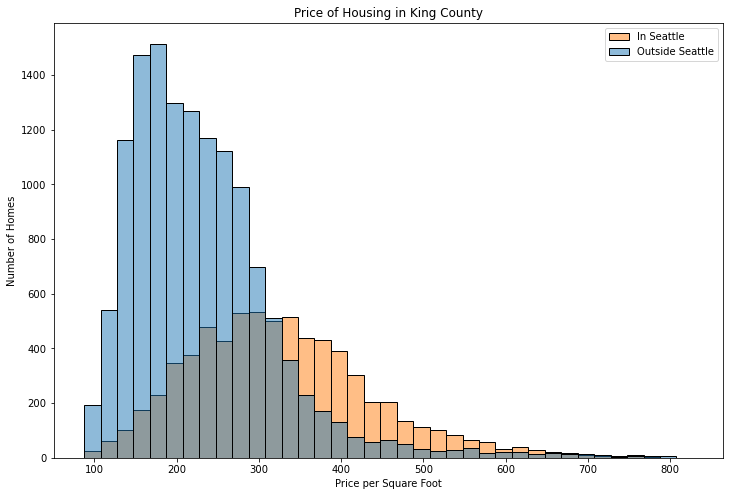

In [37]:
X_with_in_sea['price_per_sqft'] = X_with_in_sea['price'].div(X_with_in_sea['sqft_living'])

fig, ax = plt.subplots(figsize = (12,8))
sns.histplot(ax=ax, data = X_with_in_sea, x = 'price_per_sqft', hue = 'in_Seattle', binwidth = 20, alpha = .5)
ax.set_xlabel('Price per Square Foot')
ax.set_ylabel('Number of Homes')
ax.set_title('Price of Housing in King County')
ax.legend(['In Seattle','Outside Seattle']);

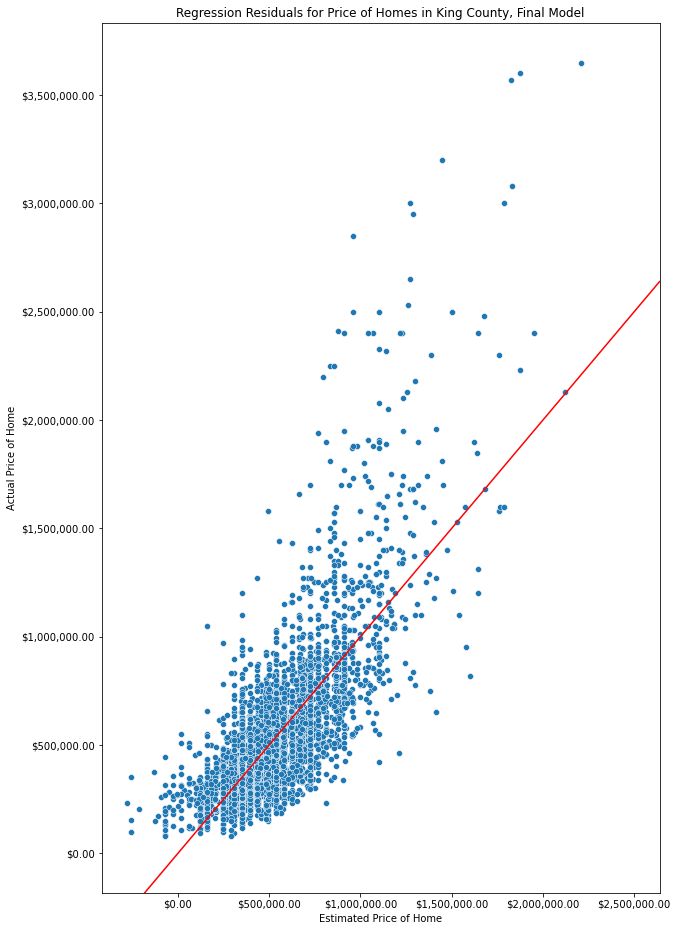

In [38]:
fig, ax = plt.subplots(figsize = (10,16))

sns.scatterplot(x = eighth_predict_test, y = y_test, ax=ax)
ax.set_title('Regression Residuals for Price of Homes in King County, Final Model')
ax.set_xlabel('Estimated Price of Home')
ax.set_ylabel('Actual Price of Home')
ax.ticklabel_format(style='plain') 
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.xaxis.set_major_formatter('${x:1,.2f}')
x,y = [range(0,2500000,500000)],[range(0,2500000,500000)]
plt.axline((0,0),(2500000,2500000), color = 'red')
plt.show()

As you can see, the model works fairly well in the lower price ranges, however, it has a tendency to undervalue pricing at higher price ranges. This is a more difficult area to model in general. However, since our stakeholder is attempting to buy low (e.g. before the error tendency grows too large) this should not effect buying positions. As far as selling at the high end, we recommend our stakeholders look to the market, not the model, for pricing choices. E.g., take several bidders to allow the market to set the price on high end properties.

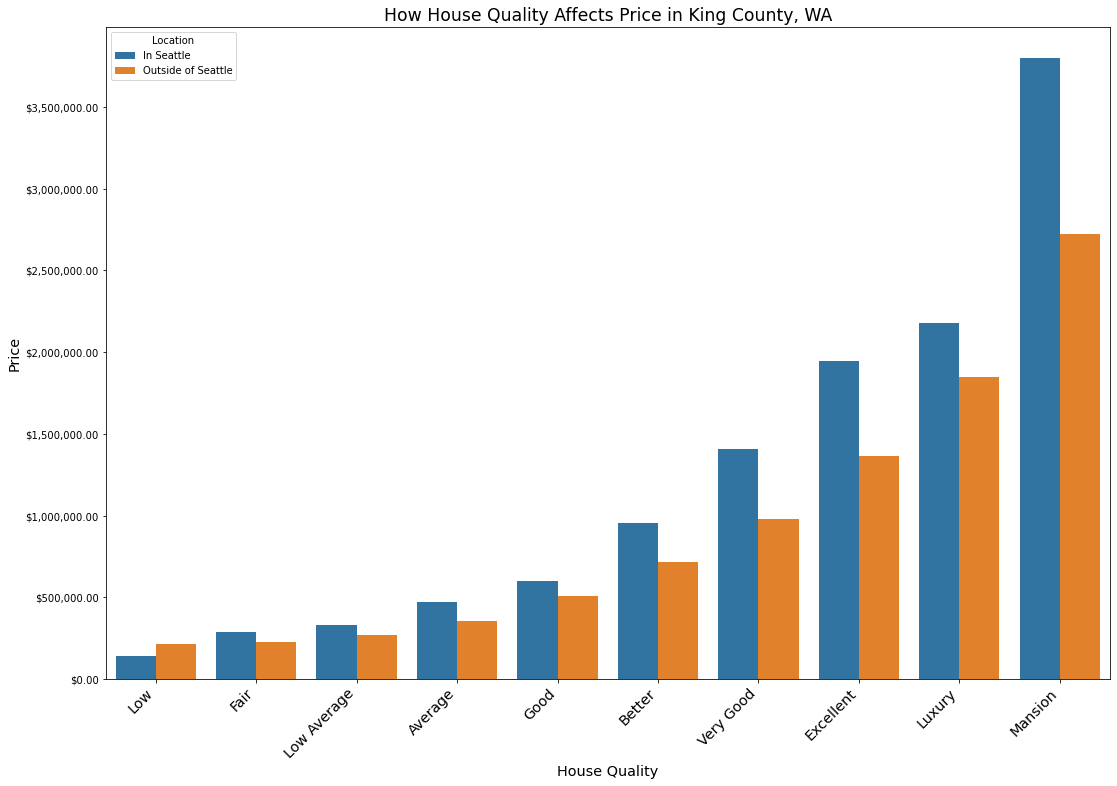

In [48]:
#begin silly work around to the legend not working

to_graph = X_with_in_sea.loc[:, ['grade_num_cat', 'price', 'in_Seattle'] ]
to_graph['in_Seattle'].replace(to_replace= [0, 1], value =['Outside of Seattle','In Seattle'], inplace= True)
to_graph.rename(columns={"in_Seattle": "Location"}, inplace = True) 

#End silly work around

fig, ax = plt.subplots(figsize = (18,12))
ax = sns.barplot(data = to_graph, x = 'grade_num_cat', y= 'price', hue = 'Location', ci = 0)
ax.set_title('How House Quality Affects Price in King County, WA', fontsize = 'xx-large')
ax.set_xlabel('House Quality', fontsize = 'x-large')
ax.set_ylabel('Price', fontsize = 'x-large')
ax.yaxis.set_major_formatter('${x:1,.2f}')
ax.set_xticklabels(['Low','Fair','Low Average', 'Average', 'Good', 'Better', 'Very Good','Excellent', 'Luxury', 'Mansion'],
                      rotation = 45, horizontalalignment = 'right', fontsize = 'x-large');

In [ ]:
#coefficients = pd.DataFrame(fourth_model.coef_,X_train_fourth_model.columns, columns=['Coefficients'])
zipcodes_price = df.groupby('zipcode').agg('mean').sort_values('price')
zipcodes_price = zipcodes_price[['price','in_Seattle','grade_num']]
zipcodes_price = zipcodes_price.sort_values(['in_Seattle','price'],ascending = [False,True])[:22]

zipcodes_price.index.tolist()

zipcodes_price

In [ ]:
zipcodes_price2 = df[df['in_Seattle'] == 1]
zipcodes_price2 = pd.pivot_table(zipcodes_price2, values = ['price'], index = ['zipcode','grade_num'], aggfunc={'price': [min,np.mean,max]})
zipcodes_price2[:50]